# Base functions

In [1]:
metrics_to_plot = [
    ("loss", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("f1-score", "f1-score"),
    ("avg_prob_class_1", "probability class seizure")
]

In [2]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np

def plot_single(axes:Axes, train_metric:np.ndarray=None, val_metric:np.ndarray=None, test_metric:np.ndarray=None, axes_x_name:str="", axes_y_name:str="", metric_name:str="Metric", show:str|int|list[int]='none', start_check:int|float=0.2, marker:bool=False, best_k:int=3, higher_is_better:bool=False):
    possibilities= ['full', 'points', 'both', 'none']
    if isinstance(show, str) and (show not in possibilities):
        raise ValueError("show '{}' not exists, choose between '{}'".format(show, "', '".join(possibilities)))
    
    marker = '.' if (marker) else None
    
    axes.set_xlabel(axes_x_name)
    axes.set_ylabel(axes_y_name)
    axes.ticklabel_format(style='scientific', axis='y', useOffset=False)
    
    _= axes.plot(train_metric, label="train", marker=marker)
    _= axes.plot(val_metric,   label="val",   marker=marker)
    
    if isinstance(start_check, float):
        start_check= round(start_check*len(train_metric))
    
    val_ascending_indeces= np.argsort(val_metric[start_check:]) + start_check
    best_k_indeces= val_ascending_indeces[-best_k:] if higher_is_better else val_ascending_indeces[:best_k]
    
    if isinstance(show, int):
        best_k_indeces = np.array([show])
        show = 'points'
    if isinstance(show, list) and isinstance(show[0], int):
        best_k_indeces = np.array(show)
        show = 'points'
    
    color= None
    if (show in ['full', 'both']):
        plot_object= axes.plot(test_metric, label="test", marker=marker)
        color = plot_object[0].get_color()
    if (show in ['points', 'both']):
        _= axes.plot(best_k_indeces, test_metric[best_k_indeces], label="test values", marker='o', linestyle="None", color=color)
        
        ymin, _ = axes.get_ylim()
        axes.vlines(x=best_k_indeces, ymin=ymin, ymax=test_metric[best_k_indeces], colors='gray', linestyles='--')
        
        vertical_offset= 10 if higher_is_better else -15
        for idx in best_k_indeces:
            test_value = test_metric[idx]                
            axes.annotate(
                text        = f"{test_value:.4f}",
                xy          = (idx, test_value),
                textcoords  = "offset points",
                xytext      = (0,vertical_offset),
                ha          = "center",
                fontsize    = 9
            )
            
            axes.annotate(
                text        = idx,
                xy          = (idx, 0),
                xycoords    = axes.get_xaxis_transform(),
                xytext      = (0, 0),
                textcoords  = "offset points",
                ha          = "center",
                va          = "top",
                fontsize    = 9,
                bbox        = dict(boxstyle="round,pad=0.3", fc="gray", alpha=0.8, edgecolor="gray")
            )
    
    axes.set_title(metric_name, loc="left")
    axes.grid(True)
    axes.legend()

In [3]:
from classes.Metric_manager import Metrics
from constant.constants_main import METRICS_EXTENTION
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import os

metrics_to_plot_idx_filename = 0
metrics_to_plot_idx_title = 1

folders_and_titles_idx_folder = 0
folders_and_titles_idx_title = 1

def plot_grid(metrics_to_plot:list[tuple[str,str]], folders_and_titles:list[tuple[str,list[str]]], show:str|int|list[int]='none', start_check:int|float=0.2, marker:bool=False, best_k:int=3, higher_is_better:bool=False, sharey:bool=True, save_path:str=None, dpi:int=200):
    num_rows = len(metrics_to_plot)
    num_cols = len(folders_and_titles)
    
    axes:np.ndarray = None
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(10*num_cols, 6*num_rows), sharey=('row' if sharey else 'none'))
    
    if isinstance(axes, Axes):
        axes = np.array([axes])
    
    if len(axes.shape) != 2:
        axes = np.expand_dims(axes, axis=-1)

    for num_col,folder_and_title in enumerate(folders_and_titles):
        col_title = "\n".join(folder_and_title[folders_and_titles_idx_title])
        
        folder = folder_and_title[folders_and_titles_idx_folder]
        folder= os.path.join(folder, sorted(os.listdir(folder), key=lambda x: int(x.split("_")[-1]) if x.split("_")[-1].isdigit() else 0)[-1])

        for num_row,metric_to_plot in enumerate(metrics_to_plot):
            metric = metric_to_plot[metrics_to_plot_idx_filename]
            title = metric_to_plot[metrics_to_plot_idx_title]
            
            folder_epoch = int(folder.split("_")[-1])
            file = os.path.join(folder, f"{metric}_{folder_epoch}.{METRICS_EXTENTION}")
            
            ax:Axes = axes[num_row, num_col]
            ax.tick_params(labelleft=True)
            
            # Add row label on the left side of each row (first column only)
            # if num_col == 0:
            #     ax.set_ylabel(metric_to_plot[metrics_to_plot_idx_title], fontsize=12, rotation=0, labelpad=40)
            #     ax.yaxis.set_label_position("left")

            # Add column label on the top of each column (first row only)
            metric_name = col_title if (num_row==0) else ""
            
            plot_single(
                ax,
                *Metrics.load(file),
                metric_name=metric_name,
                axes_y_name=title,
                show=show,
                start_check=start_check,
                marker=marker,
                best_k=best_k,
                higher_is_better=higher_is_better
            )
            
            if num_row == 0:
                ax.text(
                    x=0.5,
                    y=1.0, 
                    s=f"Fig. [{num_col+1}]",
                    transform=ax.transAxes,
                    fontsize=16,
                    color="blue",
                    va='bottom',
                )

    plt.tight_layout()
    plt.show()
    if (save_path is not None):
        if not save_path.endswith(".png"):
            save_path = save_path + ".png"
        figure.savefig(save_path, dpi=dpi, format="png")

In [42]:
from classes.Metric_manager import Metrics
from collections import defaultdict
import numpy as np
import shutil

def generate_folders_and_titles(folder:str, titles:list[str]) -> list[tuple[str, list[str]]]:
    """Generate folders_and_titles when using a k-fold. Automatic found all sub-folders for k-fold"""
    folders_and_titles = []
    for subfolder in os.listdir(folder):
        num_list = subfolder.split("_")
        try:
            for item in num_list:
                int(item)
        except Exception as e:
            continue
        
        title = titles.copy()
        title.extend([ ", ".join([ f"chb{item}" for item in num_list ]) ])
        folders_and_titles.append((os.path.join(folder, subfolder), title))
    
    return folders_and_titles

def generate_mean(original_folder:str, folders_and_titles:list[tuple[str, list[str]]], mean_folder_name:str="00"):
    """Generate mean when using a k-fold"""
    num_list = mean_folder_name.split("_")
    try:
        for item in num_list:
            int(item)
    except:
        raise ValueError("mean_folder_name must have a name like <number>[_<number>[_<number>]]...")

    mean_dir = os.path.join(original_folder, "00")
    if os.path.exists(mean_dir):
        shutil.rmtree(mean_dir)
    
    dictionary:dict[str,list[str]] = defaultdict(list)
    for path,_ in folders_and_titles:
        path= os.path.join(path, sorted(os.listdir(path), key=lambda x: int(x.split("_")[-1]) if x.split("_")[-1].isdigit() else 0)[-1])
        for file in os.listdir(path):
            dictionary[file].append( os.path.join(path, file) )

    mean_dir = os.path.join(mean_dir, os.path.basename(path))
    os.makedirs(mean_dir)

    for key,list_value in dictionary.items():
        trains  = []
        vals    = []
        for value in list_value:
            train, val, _ = Metrics.load(value)
            trains.append(train)
            vals.append(val)
        
        Metrics.save(
            file_path       = os.path.join(mean_dir, key),
            train_metric    = np.array(trains).mean(axis=0),
            val_metric      = np.array(vals).mean(axis=0)
        )

# Meeting 10/12

In [ ]:
folders_and_titles = [
    (
        "../metrics/base 0 - grezzo",
        [
        "2 Celle",
        "GL : Graph Attention (dim 70, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (cross-entropy)",
        "DATI : 12s grezzi (impuri) - cross-correlazione",
        "BATCH : 64 - [15.700]"
        ]
    ),
    (
        "../metrics/base 0 - fft",
        [
        "2 Celle",
        "GL : Graph Attention (dim 70, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - [15.700]"
        ]
    ),
    (
        "../metrics/base 1 - sampler",
        [
        "2 Celle",
        "GL : Graph Attention (dim 70, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - (2% sampler) [15.700]"
        ]
    ),
    (
        "../metrics/base 1 - sampler & pos_weight/",
        [
        "2 Celle",
        "GL : Graph Attention (dim 70, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - (2% sampler) [15.700]"
        ]
    ),
    (
        "../metrics/base 2 - (1) layer/",
        [
        "2 Celle",
        "GL : GAT (dim 70, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - (2% sampler) [15.700]"
        ]
    ),
    (
        "../metrics/base 3 - (1) head/",
        [
        "2 Celle",
        "GL : GAT (dim 128, softplus) - 1 layer - 1 head",
        "GGNN : 5 steps",
        "LR : 1e-4 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - (2% sampler) [15.700]"
        ]
    ),
    (
        "../metrics/base 3 - (3) heads/",
        [
        "2 Celle",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-4 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 - (2% sampler) [15.700]"
        ]
    ),
    (
        "../metrics/normale 1/",
        [
        "2 Celle",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-4 & 1e-5 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 & 96 - (2% sampler) [42.000]"
        ]
    ),
    (
        "../metrics/normale 1 - GRU/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-4 & 1e-5 (weighted cross-entropy)",
        "DATI : 12s fft (impuri) - cross-correlazione",
        "BATCH : 64 & 96 - (2% sampler) [42.000]"
        ]
    ),
    (
        "../metrics/normale 2/",
        [
        "2 Celle",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - cross-correlazione",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/normale 2 - GRU/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - cross-correlazione",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

plot_grid(
    metrics_to_plot=metrics_to_plot,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/plots/base"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/normale 2 - GRU/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - cross-correlazione",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/metodo 1 - plv/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - PLV",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/metodo 1 - laplacian matrix (none)/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - laplacian matrix",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/metodo 1 - scaled laplacian matrix (-1)/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - scaled laplacian matrix",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/metodo 1 - scaled laplacian matrix (+2)/",
        [
        "2 Celle - GRU (128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

plot_grid(
    metrics_to_plot=metrics_to_plot,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/plots/methods"
)

In [ ]:
# folders_and_titles = [
#     (
#         "../metrics/normale 2 - GRU/",
#         [
#         "2 Celle - GRU (128)",
#         "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
#         "GGNN : 5 steps",
#         "LR : 1e-5 & 1e-6 (weighted cross-entropy)",
#         "DATI : 4s fft (puri) - cross-correlazione",
#         "BATCH : 96 - (2% sampler) [125.000]"
#         ]
#     ),
#     (
#         "../metrics/normale 3 - cross_entropy",
#         [
#         "2 Celle - GRU (128)",
#         "GL : GAT (dim 128, softplus) - 3 layers - 8 heads",
#         "GGNN : 5 steps",
#         "LR : 1e-6 & (weighted cross-entropy)",
#         "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
#         "BATCH : 96 - (2% sampler) [125.000]"
#         ]
#     ),
#     (
#         "../metrics/normale 3 - focal_loss",
#         [
#         "2 Celle - GRU (128)",
#         "GL : GAT (dim 128, softplus) - 3 layers - 8 heads",
#         "GGNN : 5 steps",
#         "LR : 1e-6 & (weighted cross-entropy)",
#         "DATI : 4s fft (puri) - (focal_loss : 0.979 / 2.0)",
#         "BATCH : 96 - (2% sampler) [125.000]"
#         ]
#     )
# ]

# plot_grid(
#     metrics_to_plot=metrics_to_plot,
#     folders_and_titles=folders_and_titles,
#     show='none',
#     start_check=0,
#     marker=False,
#     best_k=3,
#     higher_is_better=False,
#     save_path="../metrics/plots/bigger"
# )

In [ ]:
folders_and_titles = [
    (
        "../metrics/old/cross - minmax - gatv2 - gru - none/",
        [
        "2 Celle - GRU (192)",
        "GL : GATv2 (dim 192, relu) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - various values) + normalization losses",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - min-max scaler",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
   (
        "../metrics/old/cross - minmax - transf - gru - none/",
        [
        "2 Celle - GRU (192)",
        "GL : TransformerConv (dim 192, relu, concat) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - various values) + normalization losses",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - min-max scaler",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

metrics_to_plot_old = [
    ("average_total", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("f1-score", "f1-score"),
    ("avg_prob_class_1", "probability class seizure")
]

plot_grid(
    metrics_to_plot=metrics_to_plot_old,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/plots/old"
)

# Meeting 17/12

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 0/",
        [
        "2 Celle (GRU 128)",
        "GL : GAT (dim 128, softplus) - 1 layer - 3 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 1 - no sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 1 - sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 2 - scaler/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (z_score)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 2 - regularizations/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy) - regularization terms",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 3 - no sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, relu) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (z_score)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 3 - sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (z_score)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 4 - cross-entropy/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 4 - focal loss/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

plot_grid(
    metrics_to_plot=metrics_to_plot,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[1] - base"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 4 - cross-entropy/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (weighted cross-entropy)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 4 - focal loss/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

plot_grid(
    metrics_to_plot=metrics_to_plot,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    sharey=False,
    save_path="../metrics/ZZZ - plots/[2] - differences"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 4 - focal loss/",
        [
        "2 Celle (GRU 192)",
        "GL : GAT (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 5 - softplus/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, softplus) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 5 - relu/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 5 - relu & sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

plot_grid(
    metrics_to_plot=metrics_to_plot,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[3] - improvements"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 5 - relu & sigmoid/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - auto / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.95 & 1.0/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-4 (focal loss - 0.95 / 1.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.95 & 1.5/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-4 (focal loss - 0.95 / 1.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.25 & 2.0/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.25 / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
     (
        "../metrics/solido 6 - 0.50 & 2.0/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.75 & 2.0/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.75 / 2.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 0.5",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 1.0",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 1.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 3.0",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 3.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

metrics_to_plot_for_focal_loss = [
    ("loss", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("precision", "precision"),
    ("recall", "recall"),
    ("f1-score", "f1-score"),
    ("avg_prob_class_1", "probability class seizure"),
    ("avg_prob_class_0", "probability class NOT seizure")
]

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[4] - focal_loss"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 6 - 0.50 & 0.5",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 7 - GATv2 & GRU & 2 celle/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : GRU - 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 7 - TransformerConv & Propagator & 2 celle/",
        [
        "2 Celle (GRU 192)",
        "GL : TransformerConv (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    ),
    (
        "../metrics/solido 7 - GATv2 & Propagator & 4 celle/",
        [
        "4 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

metrics_to_plot_for_focal_loss = [
    ("loss", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("precision", "precision"),
    ("recall", "recall"),
    ("f1-score", "f1-score"),
    ("avg_prob_class_1", "probability class seizure"),
    ("avg_prob_class_0", "probability class NOT seizure")
]

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[5] - loss experiment"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/3 - 2c/",
        [
        "4 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5) + regularizations (1.0 - 1.0 - 1.0)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]"
        ]
    )
]

metrics_to_plot_for_focal_loss = [
    ("loss", "loss"),
    ("loss_degree", "degree loss"),
    ("loss_smooth", "smooth loss"),
    ("loss_sparsity", "sparsity loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("precision", "precision"),
    ("recall", "recall"),
    ("f1-score", "f1-score"),
    ("avg_prob_class_1", "probability class seizure"),
    ("avg_prob_class_0", "probability class NOT seizure")
]

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[6] - regularizations"
)

In [ ]:
folders_and_titles = [
    (
        "../metrics/solido 6 - 0.50 & 0.5/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]",
        "chb02"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 0.5 (chb03)/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]",
        "chb03"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 0.5 (chb04)/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]",
        "chb04"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 0.5 (chb05)/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]",
        "chb05"
        ]
    ),
    (
        "../metrics/solido 6 - 0.50 & 0.5 (chb06)/",
        [
        "2 Celle (GRU 192)",
        "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
        "GGNN : 5 steps",
        "LR : 1e-6 (focal loss - 0.50 / 0.5)",
        "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
        "BATCH : 96 - (2% sampler) [125.000]",
        "chb06"
        ]
    )
]

metrics_to_plot_for_focal_loss = [
    ("loss", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("f1-score", "f1-score"),
    ("precision", "precision"),
    ("recall", "recall"),
    ("avg_prob_class_1", "probability class seizure"),
    ("avg_prob_class_0", "probability class NOT seizure")
]

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[7] - focal_loss 0.5 & 0.5"
)

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='full',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[7] - focal_loss 0.5 & 0.5 - test"
)

# Meeting

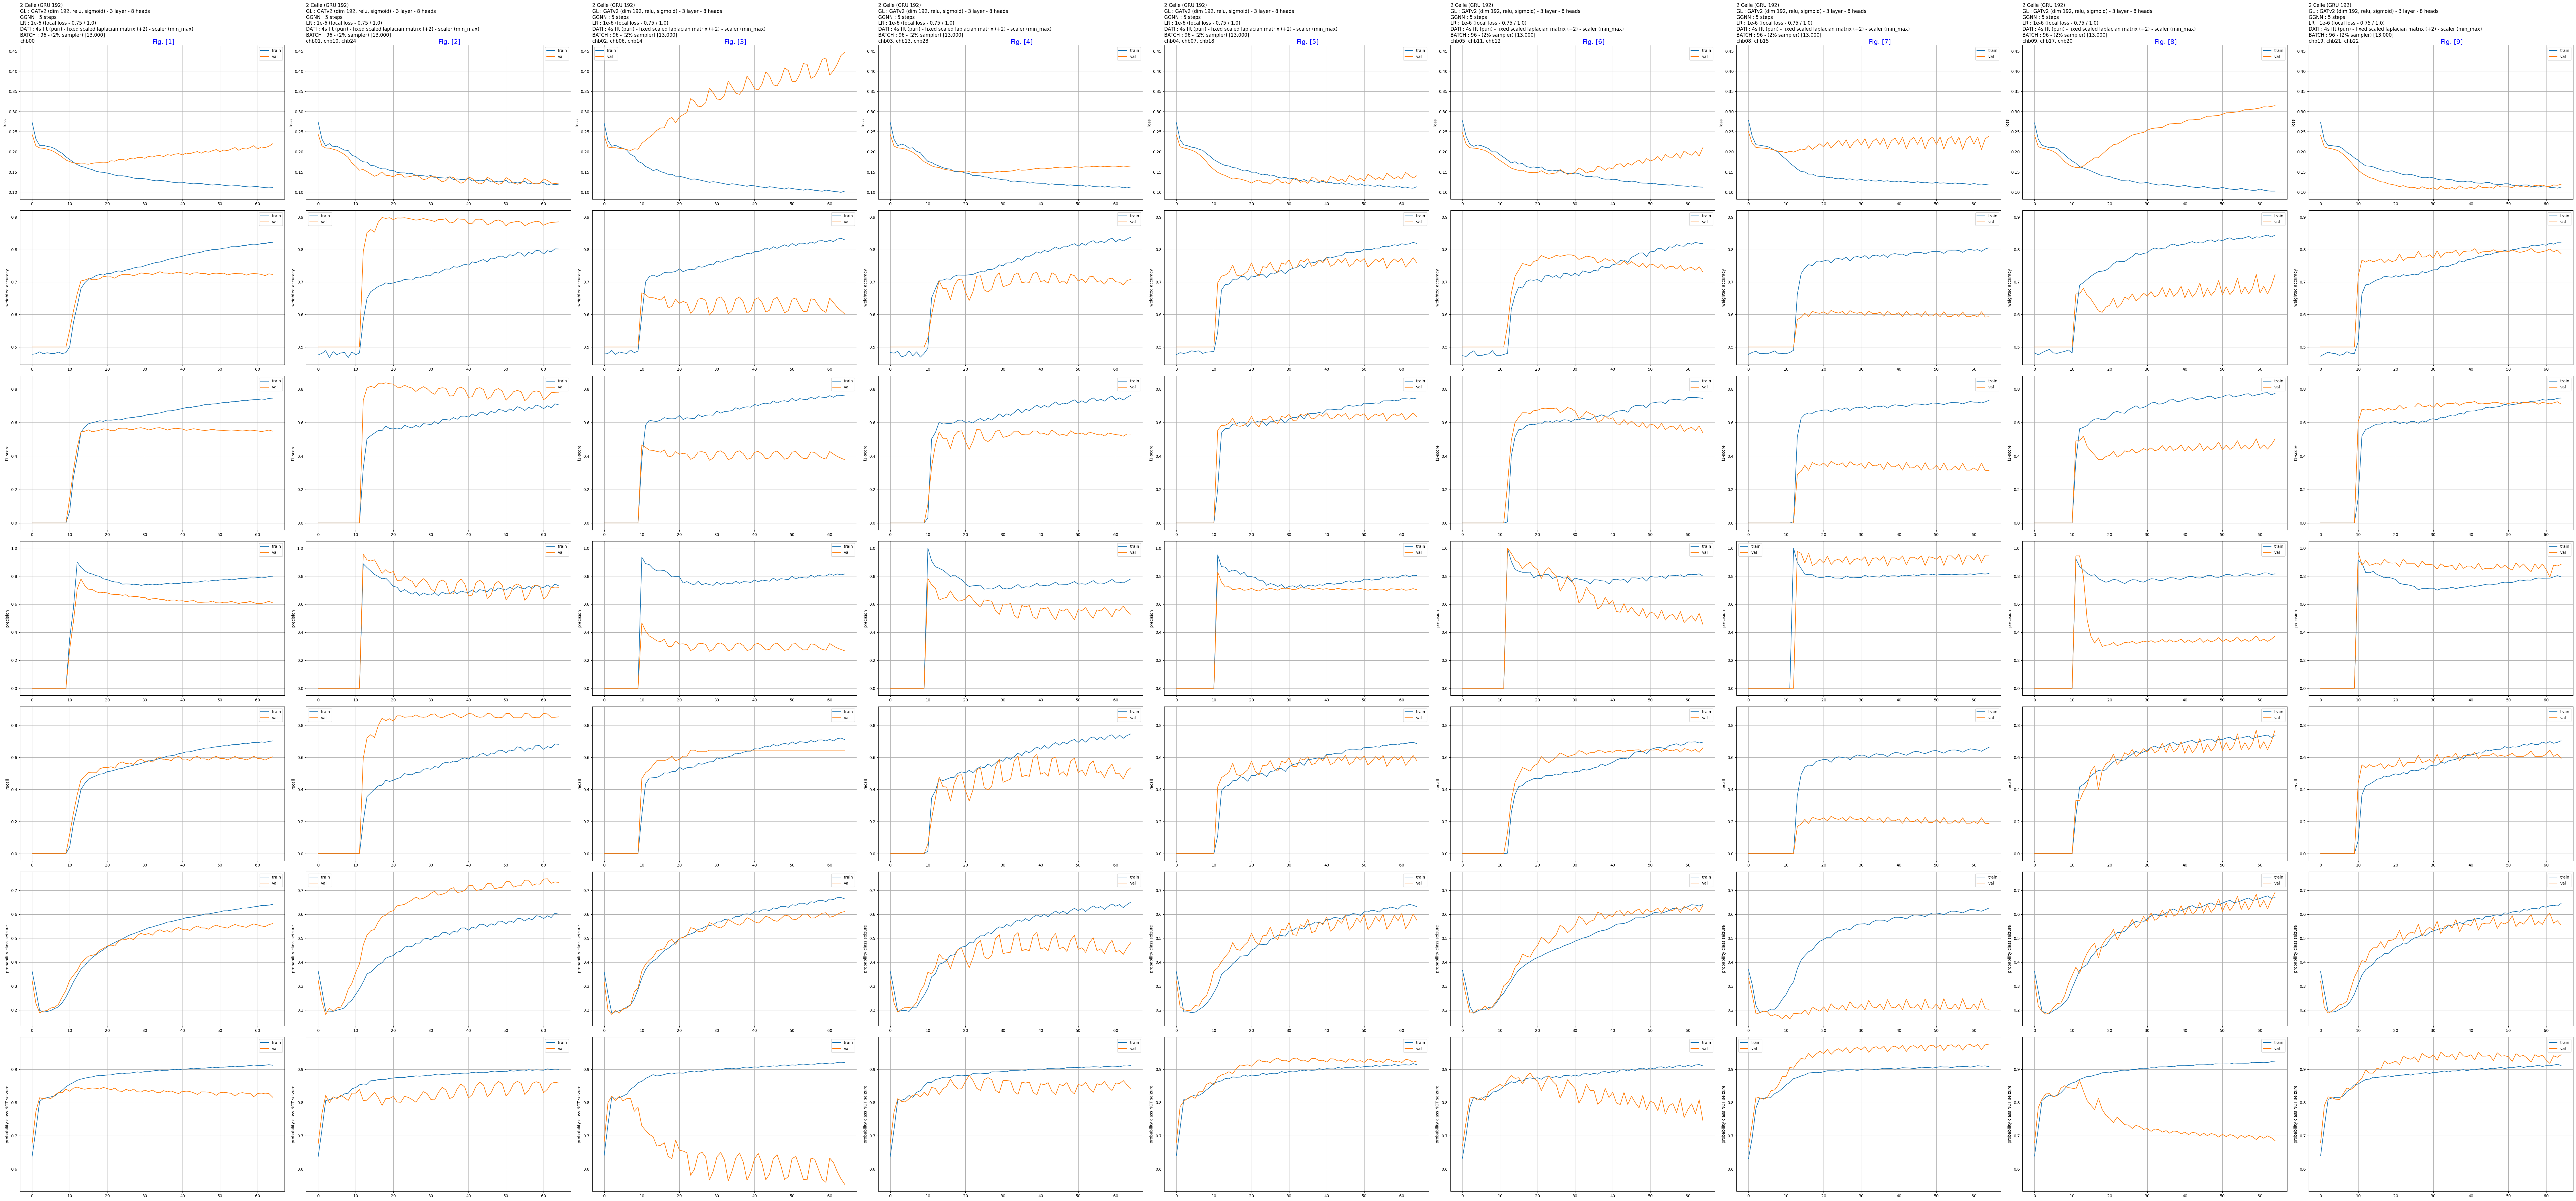

In [47]:

folder = "../metrics/k_fold 1_4/"

titles = [
    "2 Celle (GRU 192)",
    "GL : GATv2 (dim 192, relu, sigmoid) - 3 layer - 8 heads",
    "GGNN : 5 steps",
    "LR : 1e-6 (focal loss - 0.75 / 1.0)",
    "DATI : 4s fft (puri) - fixed scaled laplacian matrix (+2) - scaler (min_max)",
    "BATCH : 96 - (2% sampler) [13.000]"
]

metrics_to_plot_for_focal_loss = [
    ("loss", "loss"),
    ("weighted_accuracy", "weighted accuracy"),
    ("f1-score", "f1-score"),
    ("precision", "precision"),
    ("recall", "recall"),
    ("avg_prob_class_1", "probability class seizure"),
    ("avg_prob_class_0", "probability class NOT seizure")
]

folders_and_titles = generate_folders_and_titles(folder, titles)
generate_mean(folder, folders_and_titles)
folders_and_titles = generate_folders_and_titles(folder, titles)

plot_grid(
    metrics_to_plot=metrics_to_plot_for_focal_loss,
    folders_and_titles=folders_and_titles,
    show='none',
    start_check=0,
    marker=False,
    best_k=3,
    higher_is_better=False,
    save_path="../metrics/ZZZ - plots/[0] - test"
)